In [1]:
%matplotlib inline
# import ogr
# from osgeo import ogr
import shapely
from shapely.geometry import *
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import collections
import xml.etree.ElementTree as ET
import fiona.crs
import geopandas as gpd
from pandas.io.common import urlopen, urlencode
import pandas as pd
from six import string_types

In [3]:
import geopyspark as gps
from pyspark import SparkContext
conf = gps.geopyspark_conf(appName="osm-rasterize-example", master="local[*]")
pysc = SparkContext(conf=conf)
OSMData = collections.namedtuple('OSMData', ('nodes', 'waynodes', 'waytags',
                                             'relmembers', 'reltags'))

In [4]:
# Tags to remove so we don't clobber the output. This list comes from
# osmtogeojson's index.js (https://github.com/tyrasd/osmtogeojson)
uninteresting_tags = set([
    "source",
    "source_ref",
    "source:ref",
    "history",
    "attribution",
    "created_by",
    "tiger:county",
    "tiger:tlid",
    "tiger:upload_uuid",
])

In [5]:
from pyproj import Proj, transform, itransform
print(transform(Proj('epsg:4326'), Proj('epsg:3857'), 21, 43))
p1,p2=Proj('epsg:4326'), Proj('epsg:3857')
def translate(pts):
    return itransform(p1,p2, pts)

(4786738.104110763, 2391878.587944315)


In [6]:
def read_osm(content):
    """
    Parse OSM XML data and store as several DataFrames. Optionally "render"
    the DataFrames to GeoDataFrames.

    """
    doc = ET.parse(content)

    #   Example:
    #   <node id="1705717514" lat="42.3630798" lon="-71.0997601">
    #       <tag k="crossing" v="zebra"/>
    #       <tag k="highway" v="crossing"/>
    #       <tag k="source" v="Bing"/>
    #   </node>
    nodes = []
    for xmlnode in doc.findall('node'):
        node = xmlnode.attrib.copy()
        for t in xmlnode.findall('tag'):
            k = t.attrib['k']
            if k not in uninteresting_tags:
                node[k] = t.attrib['v']
        nodes.append(node)
        xmlnode.clear()

    #   Example:
    #   <way id="8614593">
    #       <nd ref="61326730"/>
    #       <nd ref="61326036"/>
    #       <nd ref="61321194"/>
    #       <tag k="attribution" v="Office of Geographic and Environmental Information (MassGIS)"/>
    #       <tag k="condition" v="fair"/>
    #       <tag k="created_by" v="JOSM"/>
    #       <tag k="highway" v="residential"/>
    #       <tag k="lanes" v="2"/>
    #       <tag k="massgis:way_id" v="171099"/>
    #       <tag k="name" v="Centre Street"/>
    #       <tag k="source" v="massgis_import_v0.1_20071008165629"/>
    #       <tag k="width" v="13.4"/>
    #   </way>
    waytags = []
    waynodes = []
    for xmlway in doc.findall('way'):
        wayid = xmlway.attrib['id']
        for i, xmlnd in enumerate(xmlway.findall('nd')):
            d = xmlnd.attrib.copy()
            d['id'] = wayid
            d['index'] = i
            waynodes.append(d)
            xmlnd.clear()

        tags = {'id': wayid}
        for t in xmlway.findall('tag'):
            k = t.attrib['k']
            if k not in uninteresting_tags:
                tags[k] = t.attrib['v']
            t.clear()
        waytags.append(tags)

    # Example:
    #   <relation id="1933745">
    #     <member type="way" ref="134055159" role="outer"/>
    #     <member type="way" ref="260533047" role="outer"/>
    #     <member type="way" ref="142867799" role="outer"/>
    #     <member type="way" ref="134063352" role="outer"/>
    #     <member type="way" ref="142803038" role="outer"/>
    #     <member type="way" ref="134056144" role="outer"/>
    #     <member type="way" ref="134056141" role="outer"/>
    #     <tag k="admin_level" v="8"/>
    #     <tag k="boundary" v="administrative"/>
    #     <tag k="name" v="Cambridge"/>
    #     <tag k="type" v="boundary"/>
    #     <tag k="wikipedia" v="en:Cambridge, Massachusetts"/>
    #   </relation>
    reltags = []
    relmembers = []
    for xmlrel in doc.findall('relation'):
        relid = xmlrel.attrib['id']
        for i, xmlmember in enumerate(xmlrel.findall('member')):
            d = xmlmember.attrib.copy()
            d['id'] = relid
            d['index'] = i
            relmembers.append(d)
            xmlmember.clear()

        tags = {'id': relid}
        for t in xmlrel.findall('tag'):
            k = t.attrib['k']
            if k not in uninteresting_tags:
                tags[k] = t.attrib['v']
            t.clear()
        reltags.append(tags)

    data = OSMData(*(pd.DataFrame.from_dict(x)
                     for x in (nodes, waynodes, waytags, relmembers, reltags)))
    
    # Put some columns in the right format. Return 'lon', 'lat' in nodes
    # as floats. If meta is set to True, then convert the 'timestamp'
    # field to a datetime64 so we can do all the fancy Pandas datetime
    # operations
    data.nodes['lon'] = data.nodes['lon'].astype(float)
    data.nodes['lat'] = data.nodes['lat'].astype(float)
    for df in data:
        if 'timestamp' in df:
            df['timestamp'] = pd.to_datetime(df['timestamp'])
    return data



In [7]:
df=read_osm('./map.osm')

In [8]:
# df[4]

In [9]:
def render_to_gdf(osmdata, drop_untagged=True):
    nodes, waynodes, waytags, relmembers, reltags = osmdata
    crs = fiona.crs.from_epsg(4326)

    node_points = nodes[['id', 'lon', 'lat']]

    def wayline(df):
        df = df.sort_values(by='index')[['lat','lon']]
        return LineString(translate(df.values))

    # Group the ways and create a LineString for each one.  way_lines is a
    # Series where the index is the way id and the value is the LineString.
    # Merge it with the waytags to get a single GeoDataFrame of ways
    if not osmdata.waynodes.empty:
        waynodes = waynodes.merge(node_points, left_on='ref', right_on='id',
                                  suffixes=('', '_nodes'))
        way_lines = waynodes.groupby('id').apply(wayline)
        ways = waytags.set_index('id').set_geometry(way_lines, crs=crs)
        ways.reset_index(inplace=True)
    else:
        ways = None
#     points = [Point(x['lon'], x['lat']) for i, x in nodes.iterrows()]
#     nodes.drop(['lon', 'lat'], axis=1, inplace=True)
#     nodes = nodes.set_geometry(points, crs=crs)
    if ways is not None:
        # We should get append working
        nodes = nodes.append(ways).set_geometry('geometry', crs=crs)
    return nodes

In [10]:
n=render_to_gdf(df)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [11]:
n

,CLC:code,CLC:explanation,CLC:shapeId,CLC:waterway,CLC:year,Clasificar,addr:city,addr:country,addr:full,addr:housenumber,...,timestamp,tourism,uid,user,version,visible,water,waterway,website,wetland
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-10-31 08:48:05+00:00,NaN,4170283,Ionut Paduretu,7,true,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2019-10-31 08:48:05+00:00,NaN,4170283,Ionut Paduretu,6,true,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2012-11-16 20:48:42+00:00,NaN,30383,alex-map,5,true,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-06-06 14:44:28+00:00,NaN,128281,razor74,5,true,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2016-06-06 14:44:28+00:00,NaN,128281,razor74,4,true,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130,NaN,NaN,NaN,NaN,NaN,NaN,Oradea,RO,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,river,NaN,NaN
131,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
n=n[['id','geometry']]
n

,id,geometry
0,130397390,None
1,130397391,None
2,130397393,None
3,130397394,None
4,130397396,None
...,...,...
128,544734622,"LINESTRING (2446219.227 5950078.960, 2446215.0..."
129,544734623,"LINESTRING (2445666.181 5949863.960, 2445796.0..."
130,570746236,"LINESTRING (2446711.582 5949898.612, 2446740.6..."
131,687272535,"LINESTRING (2446415.383 5949710.687, 2446515.4..."


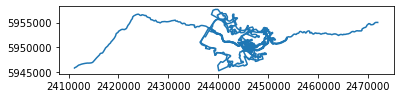

In [13]:
n.plot()

In [14]:
n=n.dropna()
geom=n['geometry'].to_numpy()
libya_roads = MultiLineString([g for g in geom])

In [38]:
# All execution time here is sending WKB over py4j socket
ro = gps.RasterizerOptions(includePartial=True, sampleType='PixelIsArea')

road_raster = gps.rasterize(geoms=list(libya_roads), 
                            crs="EPSG:3857",
                            zoom=18, 
                            fill_value=1,
                            cell_type=gps.CellType.FLOAT32,
                            options=ro)

road_raster.layer_metadata.bounds

Bounds(minKey=SpatialKey(col=146843, row=92101), maxKey=SpatialKey(col=147242, row=92181))

In [39]:
# Pyramid up from base layer
road_pp = road_raster.pyramid(resample_method=gps.ResampleMethod.MAX).cache()

In [40]:
# color map roads 1 to red
roads_cm = gps.ColorMap.from_colors(breaks=[1], color_list=[0xff000080])

# start JVM tile server and serve tiles to map
server = gps.TMS.build(source=road_pp, display=roads_cm)
server.bind("0.0.0.0")
server.url_pattern

'http://172.17.0.2:59803/tile/{z}/{x}/{y}.png'

In [41]:
from folium import Map, TileLayer

m = Map(tiles='Stamen Toner', location=[46.95,22.05], zoom_start=10)
TileLayer(tiles=server.url_pattern, attr='GeoPySpark Tiles').add_to(m)
m

In [37]:
server.unbind()